In [1]:
%pylab nbagg

import os
import functools

import h5py
import pyFAI

from collections import namedtuple
from itertools import chain
from typing import List, Tuple

from fabio.edfimage import edfimage
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

import ipywidgets as widgets


# local import
from soleil import Angle, Calibrant, CalibrationMarsTxTz, CalibrationFunctions, CalibrationMarsTxTzFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathContainsDefault, DatasetPathWithAttribute, get_dataset,\
    calibration_mars_tx_tz, integrate_mars_tx_tz, save_as_edf_mars_tx_tz

Populating the interactive namespace from numpy and matplotlib


Il y a six types de fichiers à traiter.

nb images | tz      | poni
----------|---------|
5         |  -1     | x
5         |  0      | scan3.poni
5         |  x(-1)  | x
5         |  x(0)   | scan3.poni
1         |  -1     | x
1         |  0      | scan3.poni

In [2]:
ROOT = "/home/experiences/instrumentation/picca/jupyter/mars/20160800/"
PUBLISHED = os.path.join(ROOT, "published-data")

In [14]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = 0.258705917299
poni1_scale = 0.001  # TODO
poni1_offset = 0.12  # TODO
poni2_scale = 0.001
poni2_offset = -0.9488181818181818
rot1 = 0.00388272369359
rot2 = -0.00942588451226
rot3 = 7.19961198098e-07


functions = (
    CalibrationFunctions("dist",
                         "tz * poni1_scale + poni1_offset",
                         "tx * poni2_scale + poni2_offset",
                         "rot1",
                         "rot2",
                         "rot3"),    
    [Parameter[Length]("dist", distance, (distance-0.05, distance+0.05)),
     Parameter[float]("poni1_scale", poni1_scale, (poni1_scale, poni1_scale)),
     Parameter[Length]("poni1_offset", poni1_offset, (poni1_offset-1, poni1_offset+1)),
     Parameter[float]("poni2_scale", poni2_scale, (poni2_scale, poni2_scale)),
     Parameter[Length]("poni2_offset", poni2_offset, (poni2_offset-1, poni2_offset+1)),
     Parameter[Angle]("rot1", rot1, (rot1-0.1, rot1+0.1)),
     Parameter[float]("rot2", rot2, (rot2-0.1, rot2+0.1)),
     Parameter[Angle]("rot3", rot3, (rot3-0.1, rot3+0.1))]
)

# conserve the image available for calibration, remove others
def to_use(frame: CalibrationMarsTxTzFrame) -> bool:
   
    return True if frame.idx in range(0,30) else False

def mkCalibrationMarsTxTz(filename: str, tz: float, idxs: List[int]):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd", "calibration"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               #tz, # tz
                               DatasetPathContainsDefault("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value", tz),  # tz
                               idxs,
                               to_use,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions
                              ) 
    
params = [mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_3_01.nxs"), 0.0, [2, 5, 8]),
          mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_4_01.nxs"), -1.0, [2, 5])]

In [4]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
emacs = my_cmd_button("emacs soleil.py", "Edit the soleil.py file")

In [6]:
for param in params:
    my_cmd_button("silx view --use-opengl-plot " + param.filename,
                  'Silx View ' + os.path.basename(param.filename))

In [7]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

for param in params:
    cmds = save_as_edf_mars_tx_tz(param)
    for cmd, idx in zip(cmds, param.idxs):
        my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(param.filename) + " " + str(idx))

CalibrationMarsTxTzFrame(idx=2, label='scan_3_01.nxs_2', image=array([[14, 18, 14, ..., 16, 14, 40],
       [18, 19, 12, ...,  7,  9, 66],
       [17, 12, 11, ..., 14, 18, 73],
       ..., 
       [ 3,  5,  2, ...,  0,  0,  9],
       [ 2,  5,  2, ...,  0,  0,  5],
       [ 4,  0,  0, ...,  1,  0,  5]], dtype=uint32), tx=734.00099999999998, tz=0.0)
CalibrationMarsTxTzFrame(idx=5, label='scan_3_01.nxs_5', image=array([[29, 18, 18, ..., 48, 41, 52],
       [14, 12, 12, ..., 28, 18, 30],
       [17, 12, 15, ..., 12, 17, 34],
       ..., 
       [ 1,  0,  2, ...,  7,  1, 12],
       [ 5,  2,  1, ...,  2,  3,  6],
       [ 4,  4,  2, ...,  5,  3, 14]], dtype=uint32), tx=800.00099999999998, tz=0.0)
CalibrationMarsTxTzFrame(idx=8, label='scan_3_01.nxs_8', image=array([[14, 12, 16, ..., 19, 19, 38],
       [11, 10,  9, ..., 12,  9, 23],
       [17, 12,  7, ...,  7, 12, 23],
       ..., 
       [ 1,  2,  1, ...,  3,  1,  2],
       [ 1,  0,  1, ...,  4,  3,  1],
       [ 1,  1,  1, ...,  2,  3,

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
CalibrationMarsTxTzFrame(idx=2, label='scan_3_01.nxs_2', image=array([[14, 18, 14, ..., 16, 14, 40],
       [18, 19, 12, ...,  7,  9, 66],
       [17, 12, 11, ..., 14, 18, 73],
       ..., 
       [ 3,  5,  2, ...,  0,  0,  9],
       [ 2,  5,  2, ...,  0,  0,  5],
       [ 4,  0,  0, ...,  1,  0,  5]], dtype=uint32), tx=734.00099999999998, tz=0.0)
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.568192e-01m	PONI= 1.379994e-01, -3.197165e-02m	rot1=0.008095  rot2= -0.028732  rot3= -0.000000 rad
DirectBeamDist= 256.934mm	Center: x=-261.928, y=1004.756 pix	Tilt=1.710 deg  tiltPlanRotation= -105.730 deg
CalibrationMarsTxTzFrame(idx=5, label='scan_3_01.nxs_5', image=array([[29, 18, 18, ..., 48, 41, 52],
       [14, 12, 12, ..., 28, 18, 30],
       [17, 12, 15, ..., 12, 17, 34],
       ..., 
       [ 1,  0,  2, ...,  7,  1, 12],
       [ 5,  2,  1, ...,  2,  3,  6],

<IPython.core.display.Javascript object>


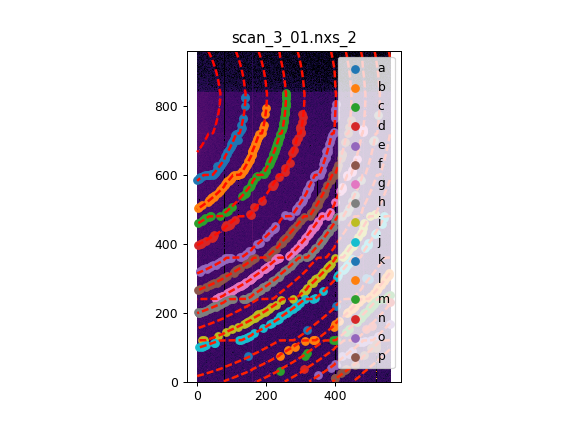

<IPython.core.display.Javascript object>


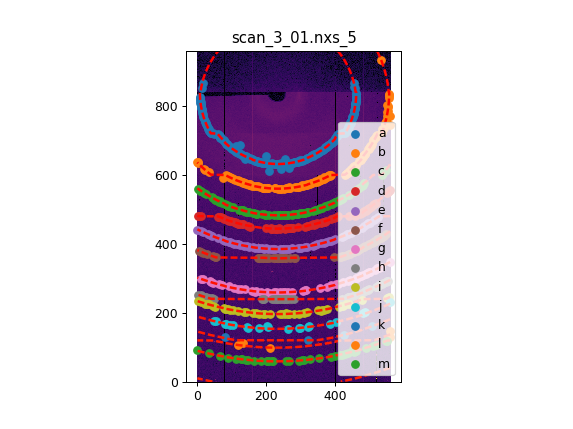

<IPython.core.display.Javascript object>


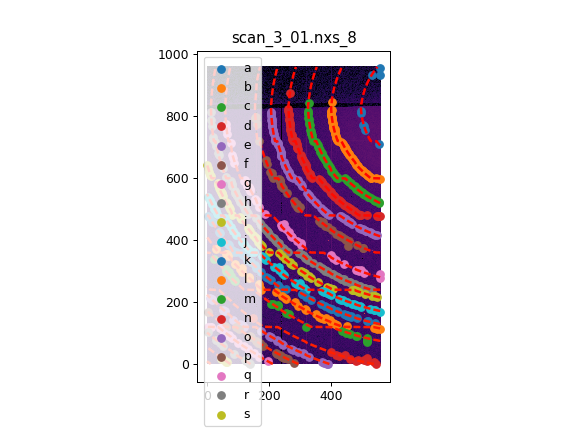

Cost function before refinement: 0.13686744926
[  2.58705917e-01   1.00000000e-03   1.20000000e-01   1.00000000e-03
  -9.48818182e-01   3.88272369e-03  -9.42588451e-03   7.19961198e-07]
     fun: 9.7576975953852929e-07
     jac: array([  2.17546798e-07,   0.00000000e+00,  -6.38259380e-07,
         5.01176143e-02,  -1.20862836e-07,   1.16804131e-08,
        -1.59753384e-07,   8.52651283e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 305
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([  2.59020956e-01,   1.00000000e-03,   1.32605515e-01,
         1.00000000e-03,  -7.66926433e-01,   6.47822598e-03,
        -8.47249394e-03,   7.18672997e-07])
Cost function after refinement: 9.75769759539e-07
GonioParam(dist=0.25902095557086757, poni1_scale=0.001, poni1_offset=0.13260551481931193, poni2_scale=0.001, poni2_offset=-0.76692643290995699, rot1=0.0064782259779978726, rot2=-0.0084724939392318305, rot3=7.1867299659752561e-07)
maxdelta on: p

scan_3_01.nxs_0
ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 5 groups of points:
# t ring 6: 34 points
# u ring 7: 43 points
# v ring 8: 47 points
# w ring 9: 50 points
# x ring 10: 51 points
[[ 624.08053528   38.00461792    6.        ]
 [ 587.99759787   10.95585691    6.        ]
 [ 611.95395913   32.91534323    6.        ]
 [ 697.97337633   60.85000792    6.        ]
 [ 585.88614327    9.01101873    6.        ]
 [ 680.94301634   55.20284753    6.        ]
 [ 597.99787607   14.96198158    6.        ]
 [ 577.99685053    4.12275619    6.        ]
 [ 575.01248219    4.77094935    6.        ]
 [ 765.98718861   76.06305473    6.        ]
 [ 663.99401162   51.05719968    6.        ]
 [ 659.91136432   49.99052666    6.        ]
 [ 790.98911122   77.15326267    6.        ]
 [ 827.01694915   73.07799325    6.        ]
 [ 852.98309204   71.02516862    6.        ]
 [ 779.98262415   76.09814294    6.        ]
 [



scan_3_01.nxs_1
ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 6 groups of points:
# y ring 3: 36 points
# z ring 4: 46 points
#aa ring 5: 53 points
#ab ring 6: 61 points
#ac ring 7: 17 points
#ad ring 8: 64 points
[[ 745.00963231   29.98727812    3.        ]
 [ 822.82122906   37.7877095     3.        ]
 [ 760.0725106    33.04538019    3.        ]
 [ 698.99547888   10.06023171    3.        ]
 [ 731.94765      26.07527553    3.        ]
 [ 767.99251694   32.20517068    3.        ]
 [ 679.97629059    2.98188655    3.        ]
 [ 801.12450832   36.90302572    3.        ]
 [ 676.98086034    0.98059689    3.        ]
 [ 683.08876616    3.95450348    3.        ]
 [ 734.02355872   27.89607843    3.        ]
 [ 814.1506768    37.96532676    3.        ]
 [ 755.99510097   30.00801596    3.        ]
 [ 742.06075949   28.90632911    3.        ]
 [ 693.85714285    8.9047619     3.        ]
 [ 729.98790691   24.988

CalibrationMarsTxTzFrame(idx=8, label='scan_3_01.nxs_8', image=array([[14, 12, 16, ..., 19, 19, 38],
       [11, 10,  9, ..., 12,  9, 23],
       [17, 12,  7, ...,  7, 12, 23],
       ..., 
       [ 1,  2,  1, ...,  3,  1,  2],
       [ 1,  0,  1, ...,  4,  3,  1],
       [ 1,  1,  1, ...,  2,  3,  4]], dtype=uint32), tx=866.00099999999998, tz=0.0)

CalibrationMarsTxTzFrame(idx=9, label='scan_3_01.nxs_9', image=array([[17, 12, 10, ..., 27, 51, 26],
       [12, 15, 12, ..., 13, 15, 29],
       [ 5,  7,  9, ..., 10, 17, 18],
       ..., 
       [ 1,  2,  0, ...,  2,  2,  3],
       [ 0,  1,  2, ...,  2,  4,  3],
       [ 1,  0,  0, ...,  0,  2,  5]], dtype=uint32), tx=888.00099999999998, tz=0.0)

scan_3_01.nxs_9
ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 5 groups of points:
#bc ring 2: 51 points
#bd ring 3: 56 points
#be ring 4: 62 points
#bf ring 5: 67 points
#bg ring 6: 70 points
[[ 821.04977675  49



scan_3_01.nxs_10
ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 6 groups of points:
#bh ring 4: 32 points
#bi ring 5: 42 points
#bj ring 6: 52 points
#bk ring 7: 57 points
#bl ring 8: 58 points
#bm ring 9: 60 points
[[ 745.95179348  541.90786565    4.        ]
 [ 779.10859729  537.68024132    4.        ]
 [ 704.94345206  558.03551233    4.        ]
 [ 739.04116517  543.23513502    4.        ]
 [ 800.00082271  534.93747429    4.        ]
 [ 769.40673339  537.94813467    4.        ]
 [ 724.24089853  545.84585592    4.        ]
 [ 729.95784061  545.20666726    4.        ]
 [ 765.00042549  538.99418566    4.        ]
 [ 773.91946475  537.01156582    4.        ]
 [ 776.8         536.95          4.        ]
 [ 760.96212121  538.97348485    4.        ]
 [ 789.02345721  536.02136385    4.        ]
 [ 805.9240602   534.95739124    4.        ]
 [ 920.10483222  544.8390604     4.        ]
 [ 801.90015128  536.80

<IPython.core.display.Javascript object>


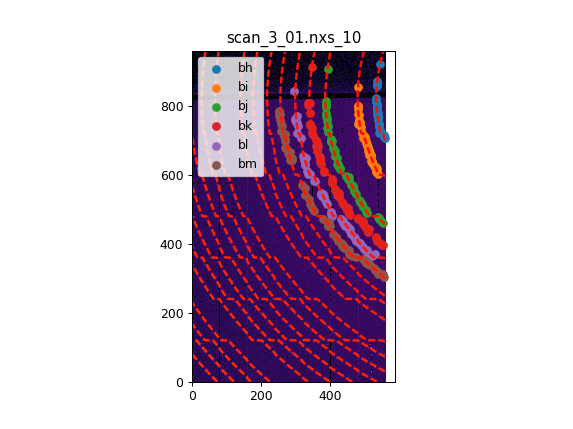

<IPython.core.display.Javascript object>


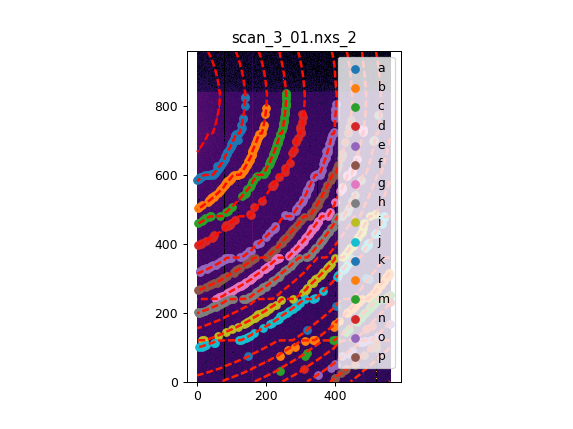

<IPython.core.display.Javascript object>


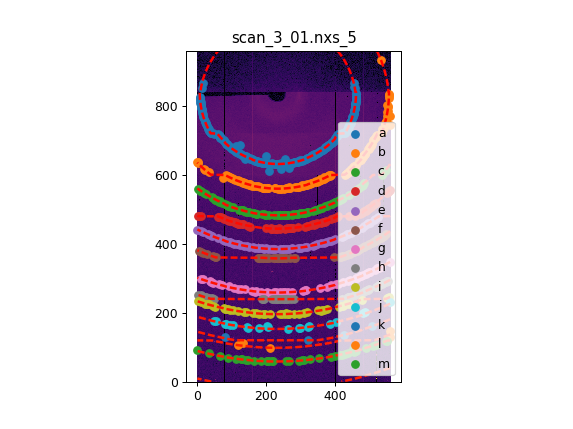

<IPython.core.display.Javascript object>


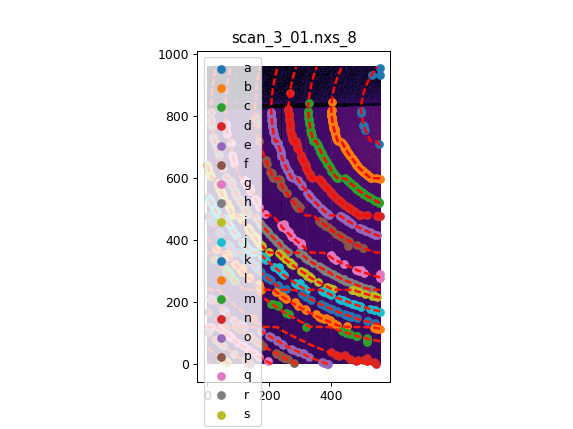

<IPython.core.display.Javascript object>


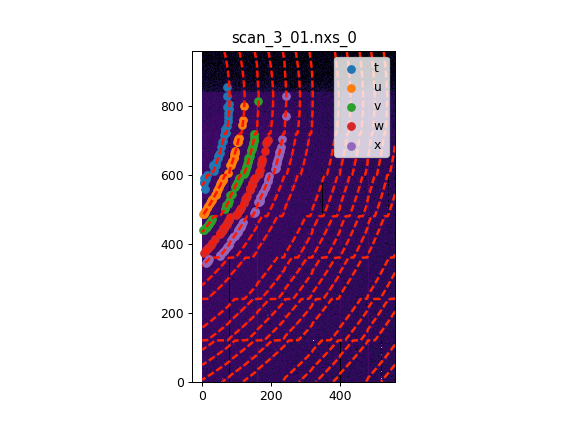

<IPython.core.display.Javascript object>


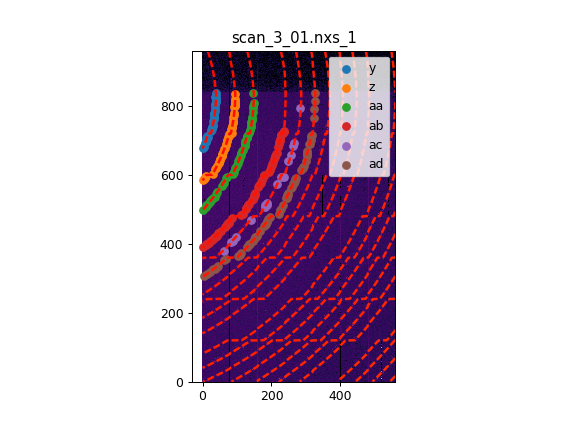

<IPython.core.display.Javascript object>


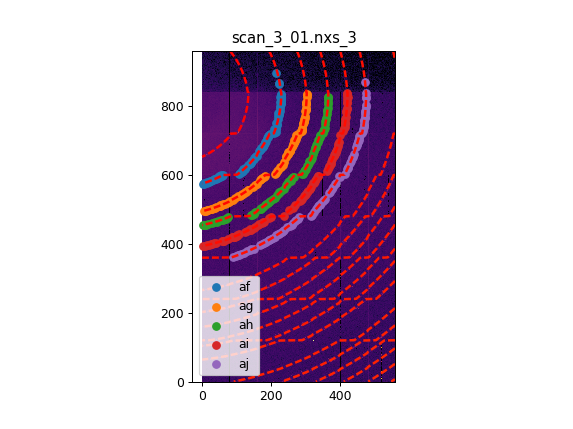

<IPython.core.display.Javascript object>


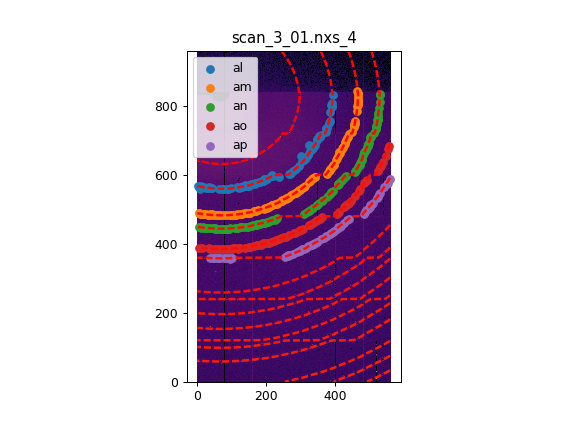

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


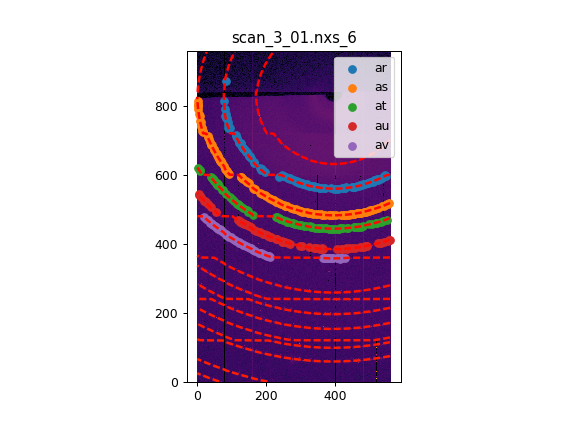

<IPython.core.display.Javascript object>


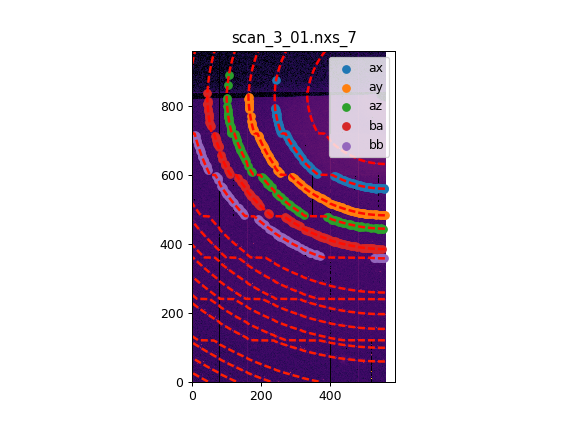

<IPython.core.display.Javascript object>


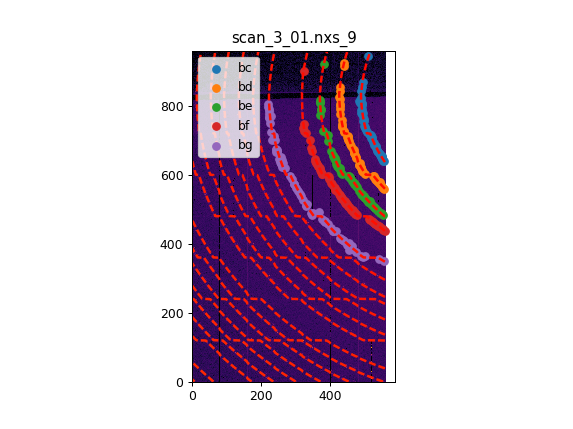

<IPython.core.display.Javascript object>


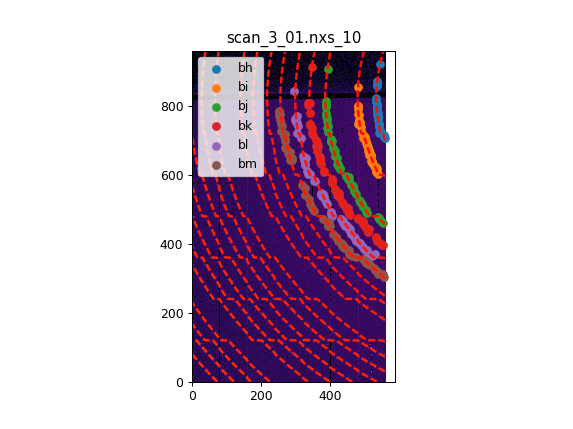

GoniometerRefinement with 11 geometries labeled: scan_3_01.nxs_2, scan_3_01.nxs_5, scan_3_01.nxs_8, scan_3_01.nxs_0, scan_3_01.nxs_1, scan_3_01.nxs_3, scan_3_01.nxs_4, scan_3_01.nxs_6, scan_3_01.nxs_7, scan_3_01.nxs_9, scan_3_01.nxs_10.
CalibrationMarsTxTzFrame(idx=2, label='scan_4_01.nxs_2', image=array([[19, 20, 13, ..., 10, 16, 46],
       [15, 16, 10, ...,  6, 10, 35],
       [19, 10, 11, ..., 13, 10, 30],
       ..., 
       [ 0,  1,  1, ...,  0,  0,  7],
       [ 2,  1,  7, ...,  0,  0,  9],
       [ 1,  1,  3, ...,  0,  1,  7]], dtype=uint32), tx=734.00099999999998, tz=-1.0)
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.580861e-01m	PONI= 1.309598e-01, -3.359912e-02m	rot1=0.003605  rot2= -0.007531  rot3= 0.000000 rad
DirectBeamDist= 258.095mm	Center: x=-265.611, y=992.430 pix	Tilt=0.478 deg  tiltPlanRotation= -115.577 deg
CalibrationMarsTxTzFrame(idx=5, label='scan_4_01.nxs_5', image=array([[19, 21, 19, ..., 11, 23, 36],
   

<IPython.core.display.Javascript object>


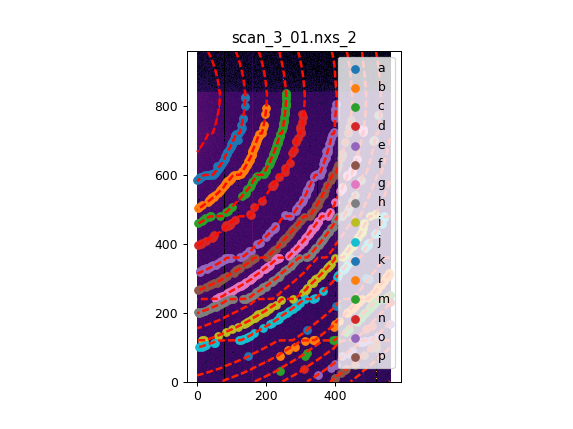

<IPython.core.display.Javascript object>


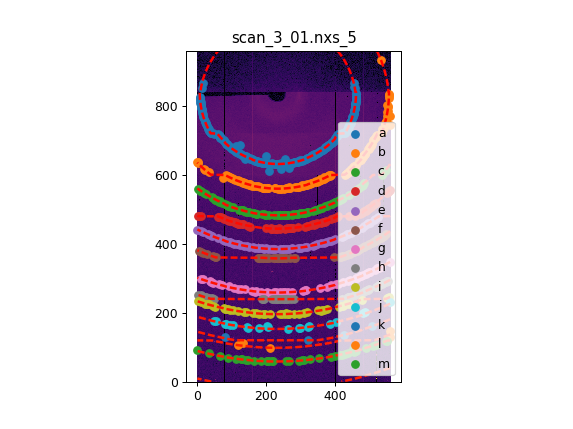

<IPython.core.display.Javascript object>


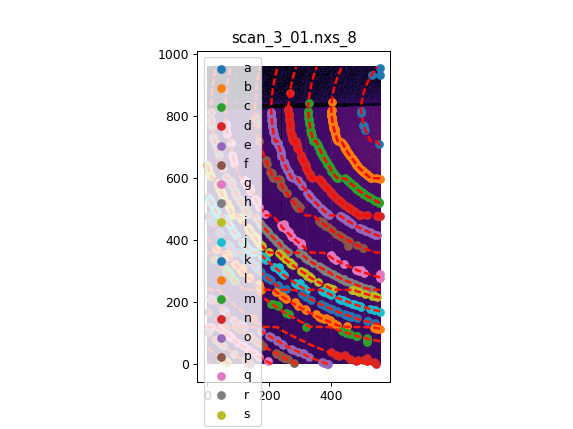

<IPython.core.display.Javascript object>


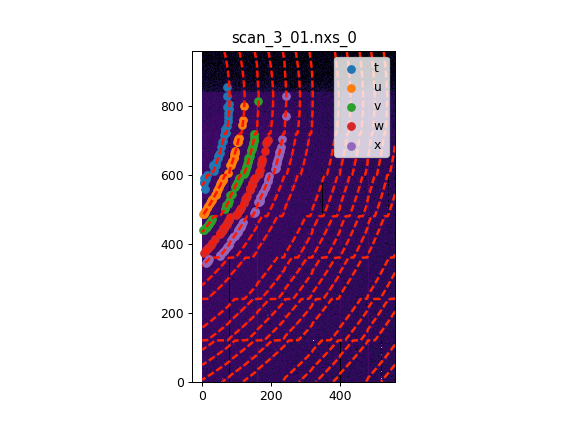

<IPython.core.display.Javascript object>


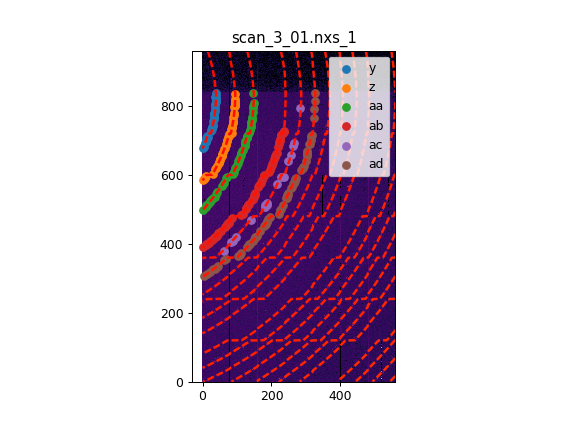

<IPython.core.display.Javascript object>


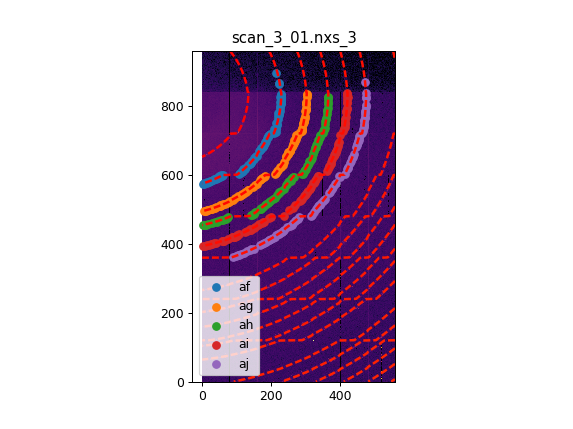

<IPython.core.display.Javascript object>


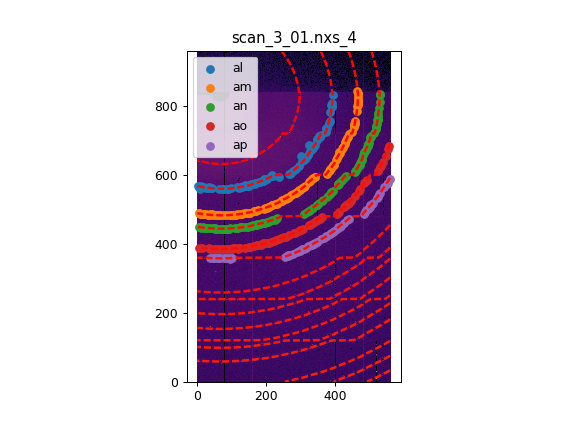

<IPython.core.display.Javascript object>


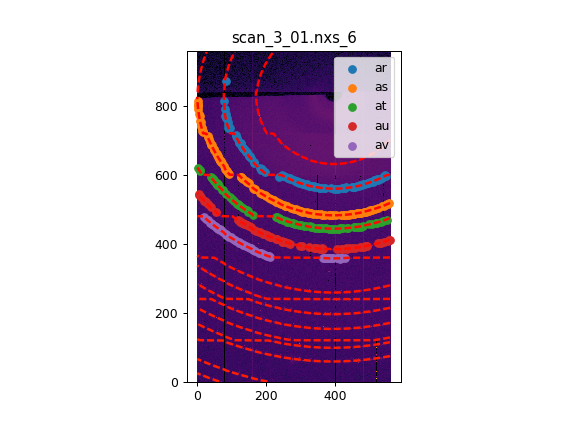

<IPython.core.display.Javascript object>


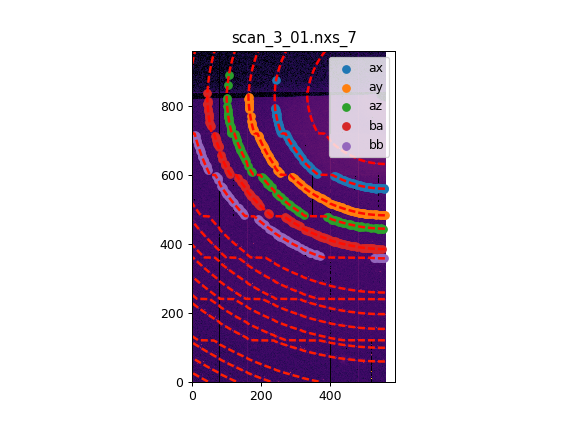

<IPython.core.display.Javascript object>


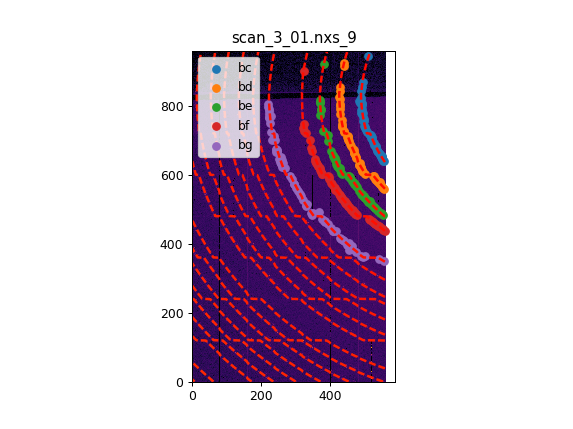

<IPython.core.display.Javascript object>


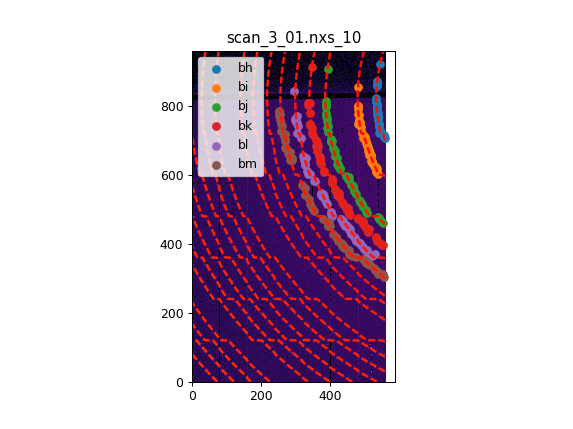

<IPython.core.display.Javascript object>


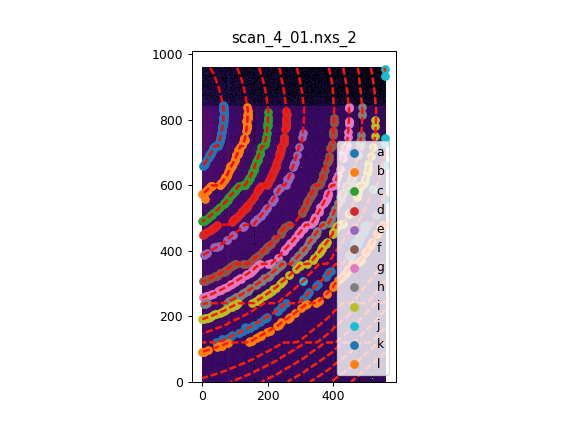

<IPython.core.display.Javascript object>


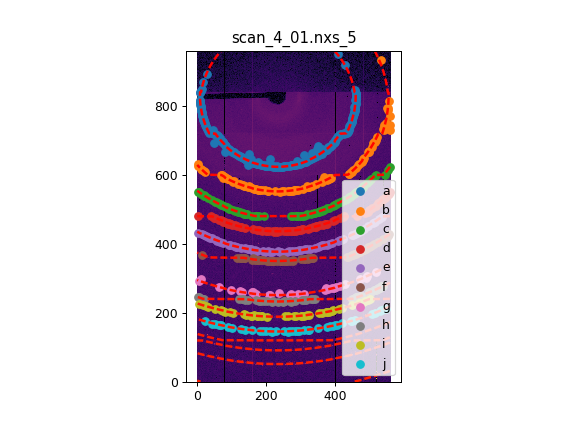

Cost function before refinement: 7.82783224053e-07
[  2.59096862e-01   1.00000000e-03   1.32540281e-01   1.00000000e-03
  -7.66262502e-01   8.89341779e-03  -8.20756101e-03   7.18645107e-07]
     fun: 7.8230997747989106e-07
     jac: array([  1.59626062e-07,   3.85331268e-06,   2.88047922e-07,
         6.20847855e-02,   1.56889755e-08,   1.32149388e-07,
         1.69248111e-07,   7.10542736e-15,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 132
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([  2.59083014e-01,   1.00000000e-03,   1.32648953e-01,
         1.00000000e-03,  -7.66157939e-01,   9.24710763e-03,
        -8.60731833e-03,   7.18674207e-07])
Cost function after refinement: 7.8230997748e-07
GonioParam(dist=0.2590830144156232, poni1_scale=0.001, poni1_offset=0.132648953252818, poni2_scale=0.001, poni2_offset=-0.76615793878380034, rot1=0.009247107626106945, rot2=-0.0086073183284254319, rot3=7.1867420733545801e-07)
maxdelta on: ro

scan_4_01.nxs_0
ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 5 groups of points:
# k ring 6: 34 points
# l ring 7: 44 points
# m ring 8: 48 points
# n ring 9: 50 points
# o ring 10: 53 points
[[ 672.99022996   55.1274779     6.        ]
 [ 708.00369239   64.88255686    6.        ]
 [ 604.57920974   32.62817976    6.        ]
 [ 595.99124799   17.98674536    6.        ]
 [ 758.00265477   76.04386188    6.        ]
 [ 690.00932004   60.81992133    6.        ]
 [ 567.14048119    4.19263566    6.        ]
 [ 590.0248816    14.95103723    6.        ]
 [ 651.98690402   49.88255145    6.        ]
 [ 616.76303728   37.79771945    6.        ]
 [ 646.02349368   46.98008071    6.        ]
 [ 582.00108339    5.01030704    6.        ]
 [ 620.87733839   32.03209365    6.        ]
 [ 570.00431482    4.04748054    6.        ]
 [ 725.00078774   65.11741464    6.        ]
 [ 788.0461455    72.03300492    6.        ]
 [



scan_4_01.nxs_1
ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 6 groups of points:
# p ring 3: 40 points
# q ring 4: 47 points
# r ring 5: 52 points
# s ring 6: 60 points
# t ring 7: 14 points
# u ring 8: 64 points
[[ 763.01097705   34.06368626    3.        ]
 [ 814.95225983   37.93973782    3.        ]
 [ 824.98665486   37.94322334    3.        ]
 [ 691.00528865   10.02194334    3.        ]
 [ 699.05096157   13.17115049    3.        ]
 [ 748.00428968   30.03810649    3.        ]
 [ 686.38584071    8.19911504    3.        ]
 [ 734.93023945   30.78622562    3.        ]
 [ 768.00203315   34.03377206    3.        ]
 [ 724.09406706   26.03652557    3.        ]
 [ 802.96664937   38.00239462    3.        ]
 [ 715.91858096   17.05041748    3.        ]
 [ 760.02484426   32.18711983    3.        ]
 [ 784.9853047    36.93110642    3.        ]
 [ 796.01301734   36.08545618    3.        ]
 [ 774.9560922    36.320

CalibrationMarsTxTzFrame(idx=9, label='scan_4_01.nxs_9', image=array([[16, 19, 11, ..., 28, 16, 26],
       [ 7, 10,  8, ..., 46, 11, 33],
       [ 8,  8,  7, ..., 12, 15, 22],
       ..., 
       [ 0,  2,  1, ...,  4,  2,  2],
       [ 2,  0,  1, ...,  1,  4,  0],
       [ 0,  2,  2, ...,  0,  3,  1]], dtype=uint32), tx=888.00099999999998, tz=-1.0)

scan_4_01.nxs_9
ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 5 groups of points:
#az ring 2: 52 points
#ba ring 3: 58 points
#bb ring 4: 63 points
#bc ring 5: 65 points
#bd ring 6: 69 points
[[ 747.98143364  498.9831519     2.        ]
 [ 683.94784182  526.71261045    2.        ]
 [ 715.05183553  512.01761521    2.        ]
 [ 671.92881209  535.19994204    2.        ]
 [ 835.28947368  489.91935484    2.        ]
 [ 689.04130884  524.03693127    2.        ]
 [ 707.04042318  519.02734851    2.        ]
 [ 732.01813832  502.03374382    2.        ]
 [ 705.985



scan_4_01.nxs_10
ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 6 groups of points:
#be ring 4: 33 points
#bf ring 5: 41 points
#bg ring 6: 52 points
#bh ring 7: 56 points
#bi ring 8: 60 points
#bj ring 9: 62 points
[[ 728.07612611  544.07527612    4.        ]
 [ 793.19006744  535.12323727    4.        ]
 [ 737.88679245  541.82075472    4.        ]
 [ 697.80373831  558.08333334    4.        ]
 [ 782.96598215  535.91053352    4.        ]
 [ 731.04301253  543.82157929    4.        ]
 [ 714.03772132  553.9301003     4.        ]
 [ 776.96138734  536.85816154    4.        ]
 [ 742.01458718  537.1060593     4.        ]
 [ 758.00044034  539.04458209    4.        ]
 [ 771.0482799   536.9629925     4.        ]
 [ 833.17703019  533.07610644    4.        ]
 [ 789.00881197  535.35137495    4.        ]
 [ 801.05850001  534.1326696     4.        ]
 [ 726.01975265  544.98594181    4.        ]
 [ 887.93939394  539.93

<IPython.core.display.Javascript object>


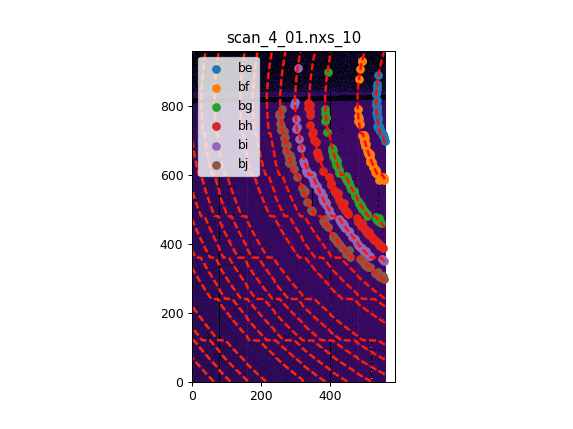

<IPython.core.display.Javascript object>


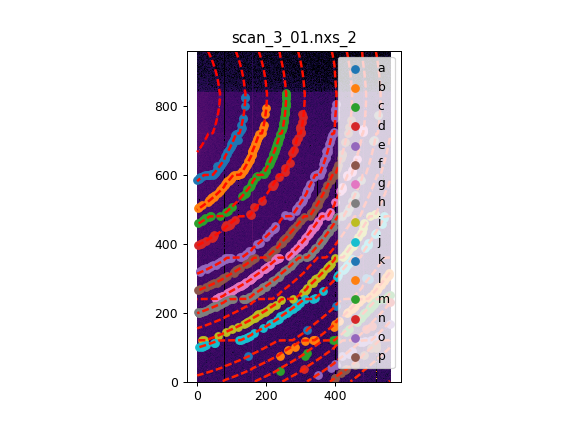

<IPython.core.display.Javascript object>


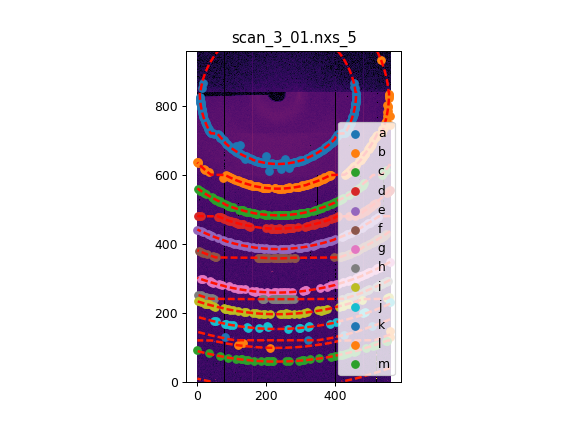

<IPython.core.display.Javascript object>


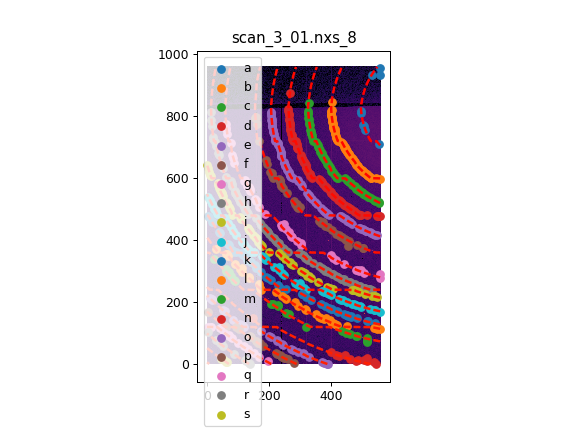

<IPython.core.display.Javascript object>


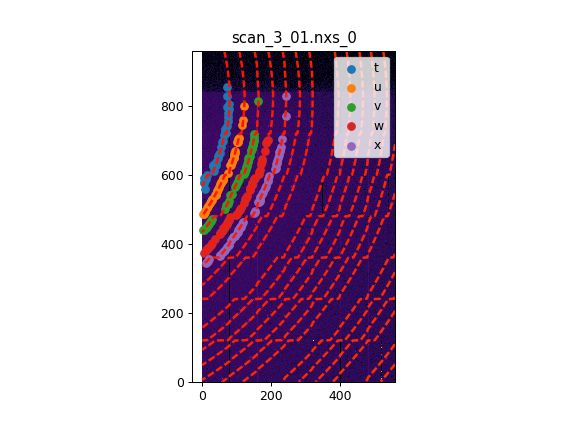

<IPython.core.display.Javascript object>


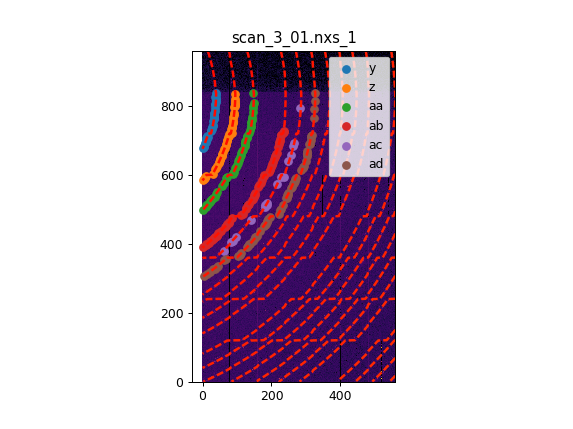

<IPython.core.display.Javascript object>


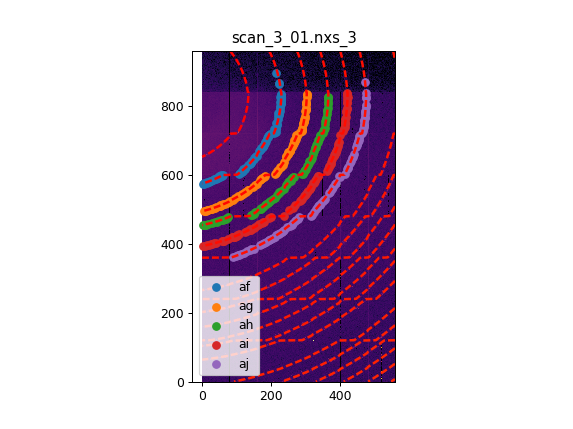

<IPython.core.display.Javascript object>


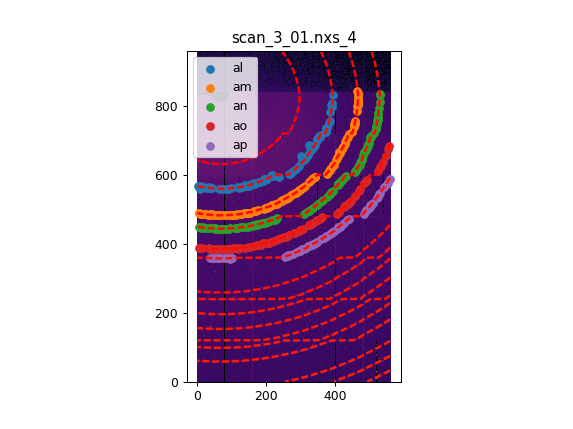

<IPython.core.display.Javascript object>


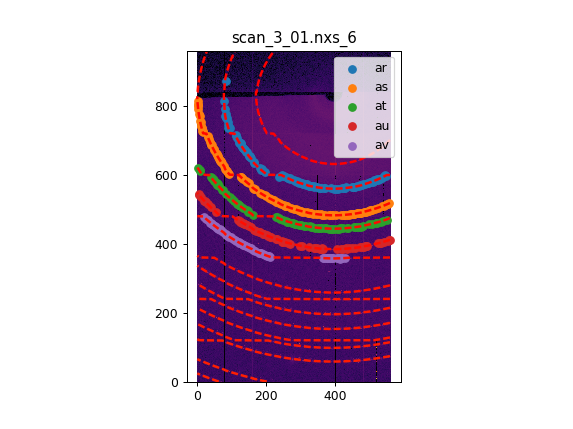

<IPython.core.display.Javascript object>


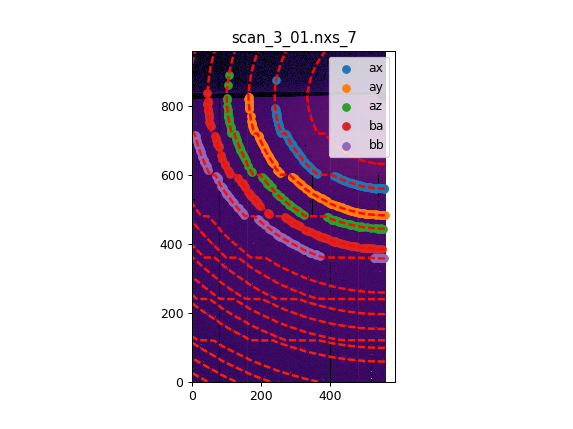

<IPython.core.display.Javascript object>


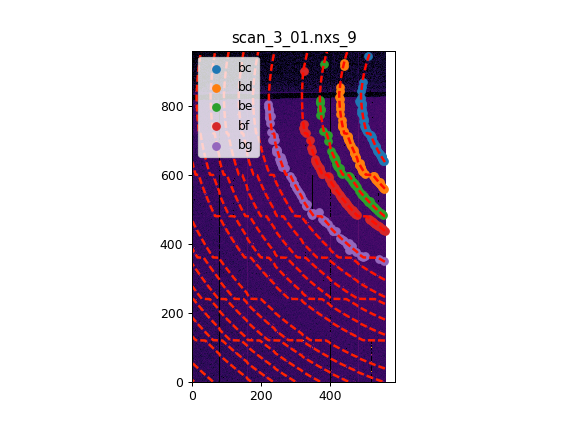

<IPython.core.display.Javascript object>


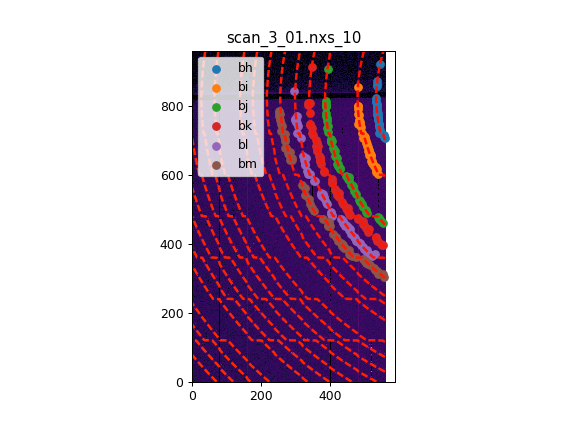

<IPython.core.display.Javascript object>


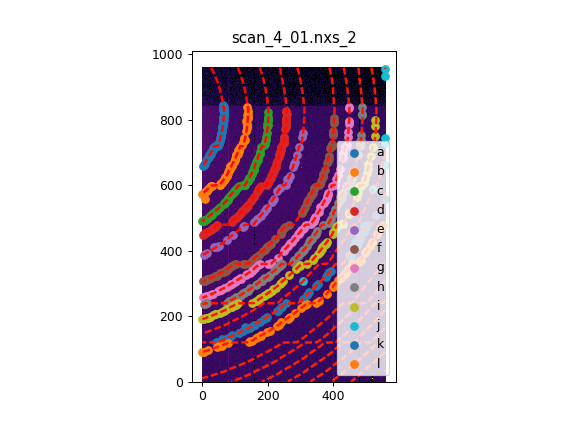

<IPython.core.display.Javascript object>


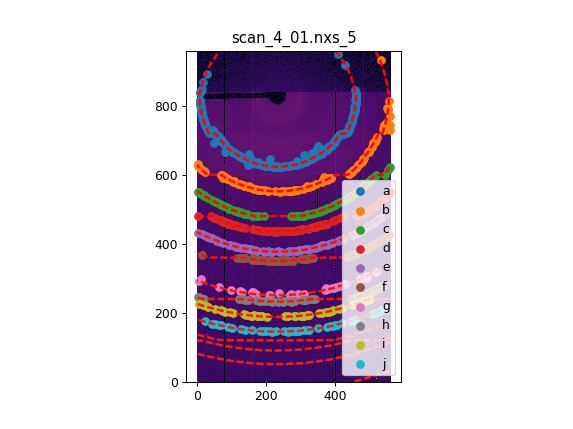

<IPython.core.display.Javascript object>


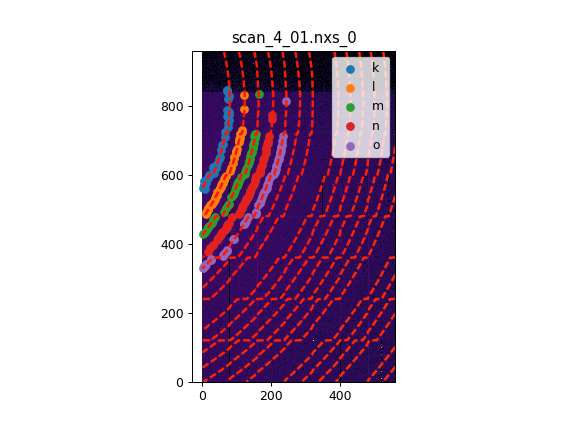

<IPython.core.display.Javascript object>


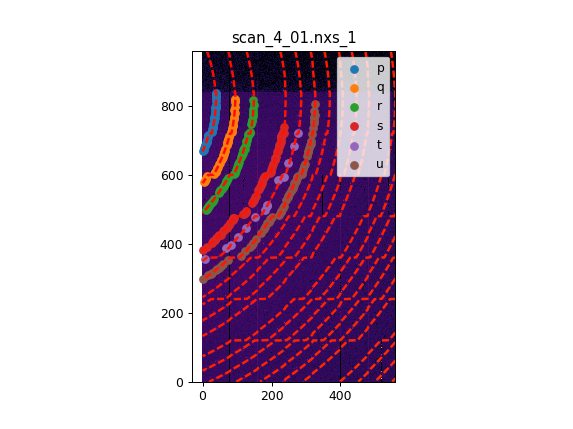

<IPython.core.display.Javascript object>


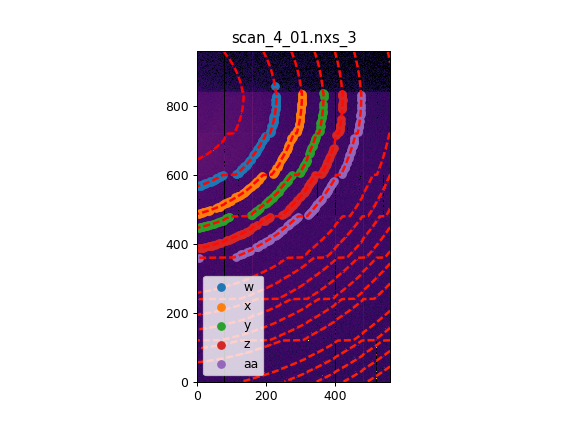

<IPython.core.display.Javascript object>


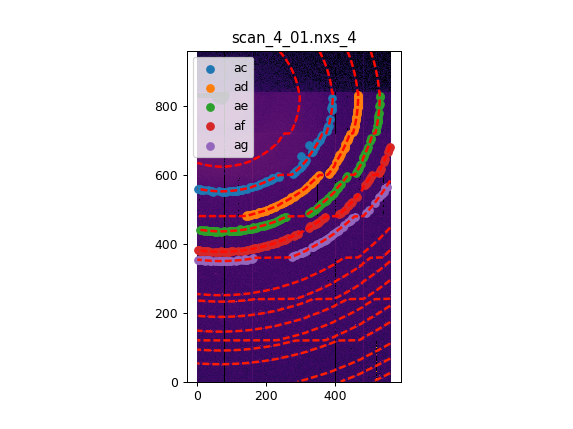

<IPython.core.display.Javascript object>


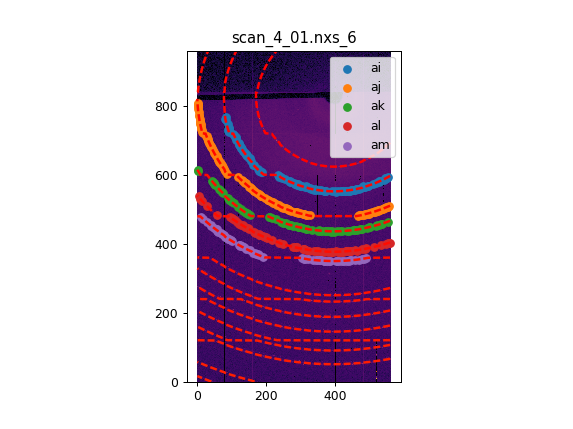

<IPython.core.display.Javascript object>


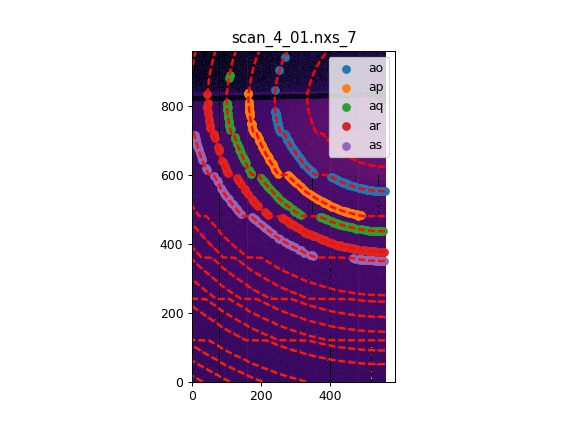

<IPython.core.display.Javascript object>


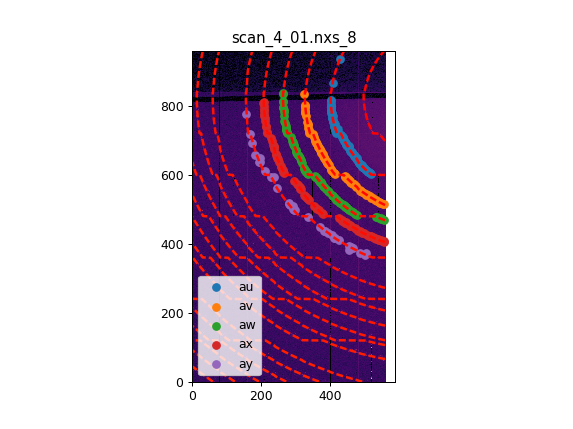

<IPython.core.display.Javascript object>


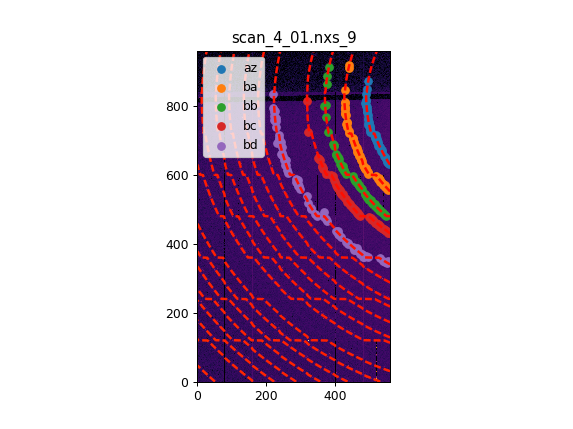

<IPython.core.display.Javascript object>


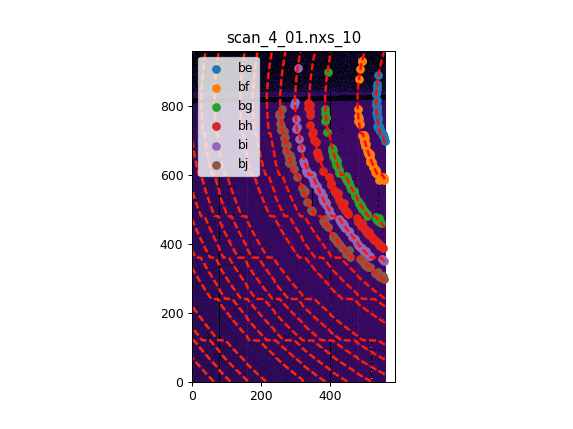

GoniometerRefinement with 22 geometries labeled: scan_3_01.nxs_2, scan_3_01.nxs_5, scan_3_01.nxs_8, scan_3_01.nxs_0, scan_3_01.nxs_1, scan_3_01.nxs_3, scan_3_01.nxs_4, scan_3_01.nxs_6, scan_3_01.nxs_7, scan_3_01.nxs_9, scan_3_01.nxs_10, scan_4_01.nxs_2, scan_4_01.nxs_5, scan_4_01.nxs_0, scan_4_01.nxs_1, scan_4_01.nxs_3, scan_4_01.nxs_4, scan_4_01.nxs_6, scan_4_01.nxs_7, scan_4_01.nxs_8, scan_4_01.nxs_9, scan_4_01.nxs_10.

In [15]:
# execute the calibration

calibration_mars_tx_tz(params, json)

CalibrationMarsTxTzFrame(idx=0, label='scan_3_01.nxs_0', image=array([[14, 19, 15, ..., 11, 14, 34],
       [15, 12, 12, ...,  5,  8, 31],
       [11, 14, 13, ...,  8, 11, 28],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  1,  1, ...,  1,  0,  1],
       [ 2,  3,  2, ...,  0,  1,  8]], dtype=uint32), tx=689.99599999999998, tz=0.0)
CalibrationMarsTxTzFrame(idx=1, label='scan_3_01.nxs_1', image=array([[ 36, 359,  89, ...,  10,   7,  57],
       [ 27, 335,  62, ...,   4,   8,  32],
       [ 11,  19,  14, ...,  10,   9,  22],
       ..., 
       [  1,   1,   1, ...,   3,   0,   3],
       [  0,   2,   0, ...,   0,   0,   4],
       [  6,   4,   3, ...,   0,   1,   5]], dtype=uint32), tx=712.00099999999998, tz=0.0)
CalibrationMarsTxTzFrame(idx=2, label='scan_3_01.nxs_2', image=array([[14, 18, 14, ..., 16, 14, 40],
       [18, 19, 12, ...,  7,  9, 66],
       [17, 12, 11, ..., 14, 18, 73],
       ..., 
       [ 3,  5,  2, ...,  0,  0,  9],
       [ 2,  5,  2, ...,  0,  0,  

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


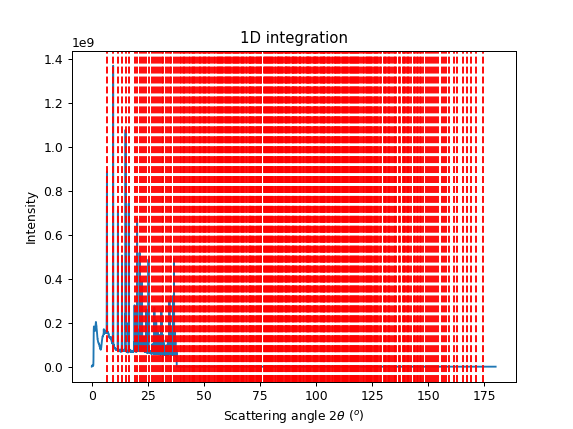

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([       0.        ,        0.        ,  4021141.94150236, ...,
               0.        ,        0.        ,        0.        ]))

In [9]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)

In [10]:
# il faudrait fair eune calibration avec l'ensemble des fichiers des scan3 et 4.
# scan3 10 images tx variant et tz=0.
# scan4 10 imagfes tx variant et tz = -1.

# TODO add the second scan for the calibration.
# TODO mask

In [11]:
# extraction des scans avec 6 positions en tx, quelque soit tz.
# CEs ont les seuls que nous pouvons traiter pour l'instant car
# la calibration n'a été faite que pour un tx de 6.
# LONG
import glob

files = glob.glob(os.path.join(ROOT, "*.nxs"))

def is_ok(filename: str) -> bool:
    with h5py.File(filename, mode='r') as f:
        for imgs, tx, tz in zip(get_images(f), get_tx(f), get_tz(f)):
            return True if tx.shape[0] == 6 else False

#good = [f for f in files if is_ok(f)]
#print(good)

CalibrationMarsTxTzFrame(idx=0, label='scan_77_01.nxs_0', image=array([[ 74,  62,  75, ...,  51,  41, 163],
       [ 48,  66,  63, ...,  40,  43, 144],
       [ 54,  56,  56, ...,  42,  30, 140],
       ..., 
       [  0,   1,   0, ...,   2,   0,   1],
       [  0,   1,   1, ...,   0,   1,   1],
       [  2,   0,   1, ...,   1,   0,   0]], dtype=uint32), tx=690.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_77_01.nxs_1', image=array([[109, 100,  92, ...,  64,  70, 206],
       [103,  99,  69, ...,  57,  57, 183],
       [ 83,  70,  72, ...,  41,  49, 186],
       ..., 
       [  1,   1,   0, ...,   0,   0,   2],
       [  1,   3,   1, ...,   1,   0,   1],
       [  2,   1,   0, ...,   1,   0,   1]], dtype=uint32), tx=734.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_77_01.nxs_2', image=array([[106, 117, 127, ..., 106,  93, 234],
       [ 95, 117,  69, ...,  91,  93, 200],
       [ 92,  86,  76, ...,  92,  91, 

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


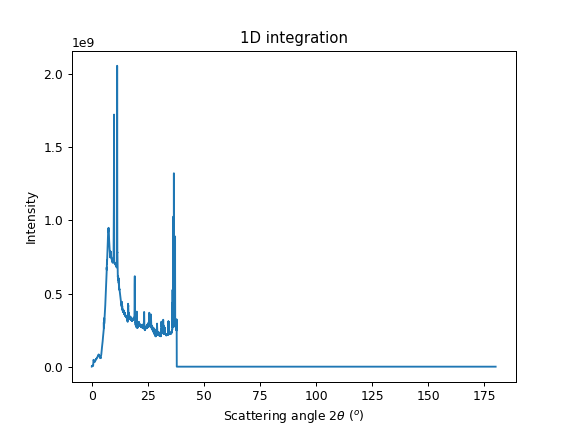

CalibrationMarsTxTzFrame(idx=0, label='scan_79_01.nxs_0', image=array([[ 58,  48,  61, ...,  39,  41, 135],
       [ 23,  40,  41, ...,  30,  44, 125],
       [ 26,  38,  59, ...,  31,  32, 112],
       ..., 
       [  0,   0,   0, ...,   1,   1,   1],
       [  0,   1,   0, ...,   1,   0,   3],
       [  1,   0,   0, ...,   2,   0,   1]], dtype=uint32), tx=690.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_79_01.nxs_1', image=array([[ 87,  83,  84, ...,  60,  55, 165],
       [ 69,  76,  64, ...,  53,  46, 150],
       [ 81,  74,  61, ...,  50,  34, 142],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   0, ...,   1,   0,   2],
       [  2,   2,   1, ...,   0,   0,   4]], dtype=uint32), tx=733.99599999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_79_01.nxs_2', image=array([[ 87,  88,  75, ...,  84,  83, 174],
       [ 58,  77,  67, ...,  64,  68, 155],
       [ 74,  60,  67, ...,  60,  62, 

<IPython.core.display.Javascript object>


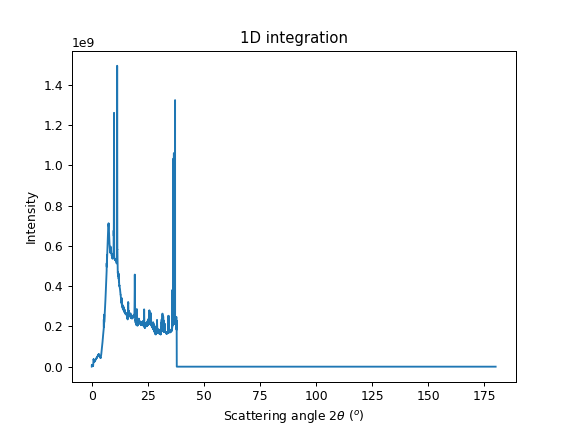

CalibrationMarsTxTzFrame(idx=0, label='scan_81_01.nxs_0', image=array([[ 42,  35,  51, ...,  26,  31, 150],
       [ 28,  36,  34, ...,  22,  23, 104],
       [ 25,  38,  43, ...,  33,  25, 120],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   1,   0,   1],
       [  0,   0,   1, ...,   0,   0,   1]], dtype=uint32), tx=690.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_81_01.nxs_1', image=array([[ 66,  63,  81, ...,  50,  42, 150],
       [ 59,  58,  43, ...,  36,  39, 133],
       [ 42,  58,  50, ...,  15,  29, 106],
       ..., 
       [  1,   0,   0, ...,   0,   2,   2],
       [  0,   0,   1, ...,   0,   0,   1],
       [  1,   0,   1, ...,   0,   0,   2]], dtype=uint32), tx=734.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_81_01.nxs_2', image=array([[ 59,  62,  62, ...,  76,  56, 153],
       [ 68,  71,  42, ...,  58,  54, 128],
       [ 54,  47,  58, ...,  66,  51, 

<IPython.core.display.Javascript object>


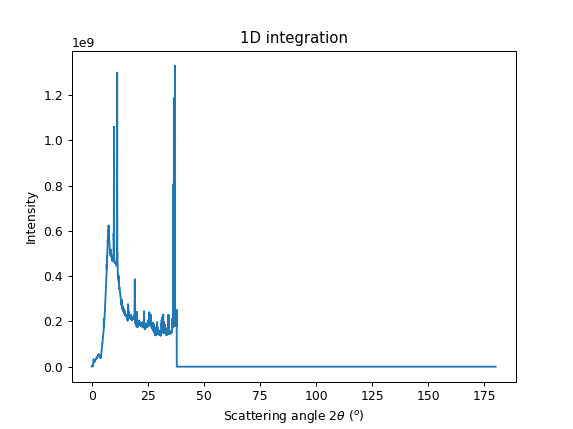

CalibrationMarsTxTzFrame(idx=0, label='scan_83_01.nxs_0', image=array([[ 35,  47,  52, ...,  32,  21,  96],
       [ 32,  36,  35, ...,  21,  18, 104],
       [ 23,  36,  33, ...,  17,  23,  85],
       ..., 
       [  0,   0,   0, ...,   0,   0,   3],
       [  0,   0,   0, ...,   0,   1,   1],
       [  0,   0,   0, ...,   1,   0,   0]], dtype=uint32), tx=689.99599999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_83_01.nxs_1', image=array([[ 37,  53,  48, ...,  34,  41, 111],
       [ 49,  44,  31, ...,  21,  32, 112],
       [ 50,  61,  40, ...,  32,  27,  98],
       ..., 
       [  1,   1,   0, ...,   0,   0,   2],
       [  0,   1,   0, ...,   0,   1,   1],
       [  0,   0,   0, ...,   1,   0,   3]], dtype=uint32), tx=734.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_83_01.nxs_2', image=array([[ 57,  46,  59, ...,  62,  52, 119],
       [ 52,  54,  56, ...,  41,  58, 144],
       [ 52,  52,  48, ...,  55,  47, 

<IPython.core.display.Javascript object>


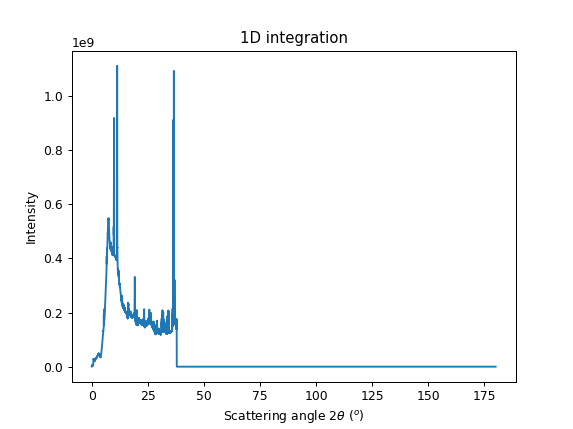

CalibrationMarsTxTzFrame(idx=0, label='scan_85_01.nxs_0', image=array([[ 37,  42,  28, ...,  14,  19, 109],
       [ 20,  22,  30, ...,  26,  11,  59],
       [ 17,  32,  39, ...,  25,  23,  98],
       ..., 
       [  1,   0,   0, ...,   0,   0,   2],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint32), tx=690.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_85_01.nxs_1', image=array([[ 53,  46,  52, ...,  34,  30, 105],
       [ 59,  39,  41, ...,  39,  25, 103],
       [ 49,  35,  46, ...,  23,  21,  91],
       ..., 
       [  0,   0,   1, ...,   0,   0,   2],
       [  2,   0,   0, ...,   0,   1,   3],
       [  0,   1,   1, ...,   1,   0,   4]], dtype=uint32), tx=734.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_85_01.nxs_2', image=array([[ 58,  46,  58, ...,  54,  54,  91],
       [ 39,  38,  52, ...,  40,  49, 101],
       [ 45,  42,  26, ...,  48,  39, 

<IPython.core.display.Javascript object>


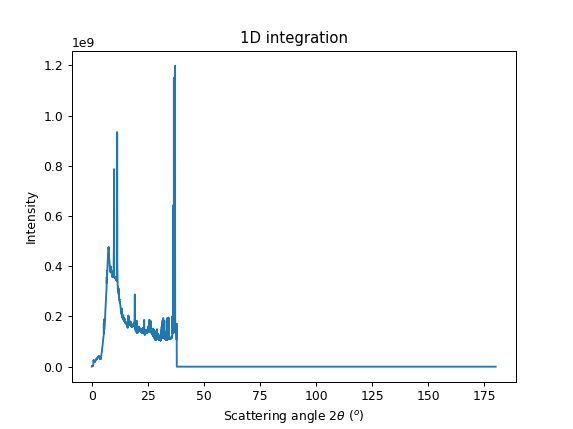

CalibrationMarsTxTzFrame(idx=0, label='scan_87_01.nxs_0', image=array([[31, 32, 29, ..., 22, 21, 83],
       [24, 17, 29, ..., 20, 20, 70],
       [19, 28, 28, ..., 21, 14, 79],
       ..., 
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  3],
       [ 0,  0,  0, ...,  3,  1,  0]], dtype=uint32), tx=690.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_87_01.nxs_1', image=array([[ 51,  52,  42, ...,  25,  26, 110],
       [ 34,  37,  36, ...,  24,  26,  89],
       [ 36,  39,  32, ...,  27,  21,  73],
       ..., 
       [  1,   0,   0, ...,   0,   0,   2],
       [  2,   0,   0, ...,   0,   0,   0],
       [  0,   0,   1, ...,   2,   1,   1]], dtype=uint32), tx=733.99599999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_87_01.nxs_2', image=array([[62, 57, 47, ..., 56, 50, 97],
       [32, 40, 29, ..., 44, 43, 96],
       [55, 34, 41, ..., 40, 52, 93],
       ..., 
       [ 2,  0,  0, ...,  1,  0,  3

<IPython.core.display.Javascript object>


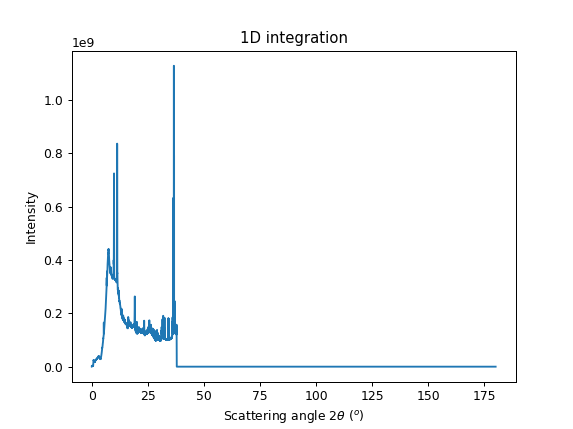

CalibrationMarsTxTzFrame(idx=0, label='scan_89_01.nxs_0', image=array([[25, 24, 31, ..., 23, 17, 99],
       [20, 23, 25, ..., 25, 11, 75],
       [15, 22, 22, ..., 21, 16, 61],
       ..., 
       [ 0,  1,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  1]], dtype=uint32), tx=690.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_89_01.nxs_1', image=array([[54, 38, 45, ..., 34, 21, 81],
       [33, 35, 39, ..., 23, 31, 85],
       [38, 30, 37, ..., 16, 16, 82],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32), tx=734.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_89_01.nxs_2', image=array([[ 51,  36,  50, ...,  36,  37, 116],
       [ 39,  42,  35, ...,  33,  33,  91],
       [ 39,  32,  28, ...,  43,  39,  73],
       ..., 
       [  0,   0,   1, ...,   0,   0,   0],
       [ 

<IPython.core.display.Javascript object>


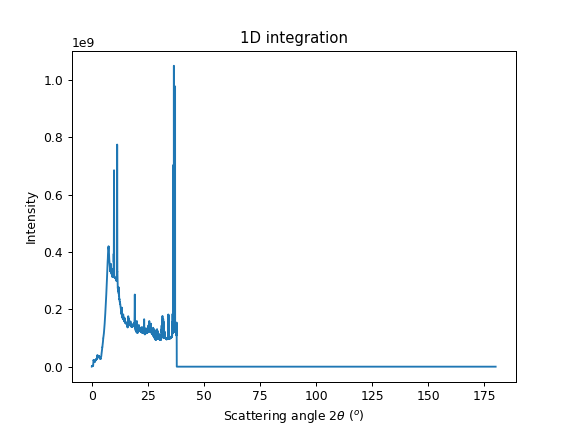

CalibrationMarsTxTzFrame(idx=0, label='scan_91_01.nxs_0', image=array([[31, 37, 31, ..., 24, 27, 86],
       [21, 17, 27, ..., 12, 17, 60],
       [25, 17, 22, ..., 15, 18, 53],
       ..., 
       [ 0,  0,  1, ...,  0,  0,  1],
       [ 0,  0,  1, ...,  0,  0,  2],
       [ 0,  2,  0, ...,  0,  0,  0]], dtype=uint32), tx=689.99599999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=1, label='scan_91_01.nxs_1', image=array([[41, 46, 47, ..., 34, 28, 92],
       [33, 37, 31, ..., 29, 15, 84],
       [36, 33, 31, ..., 26, 14, 90],
       ..., 
       [ 1,  2,  0, ...,  1,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  2],
       [ 3,  1,  0, ...,  0,  0,  2]], dtype=uint32), tx=734.00099999999998, tz=-0.99960000000000004)
CalibrationMarsTxTzFrame(idx=2, label='scan_91_01.nxs_2', image=array([[41, 34, 43, ..., 43, 53, 88],
       [43, 44, 35, ..., 34, 40, 86],
       [34, 39, 36, ..., 40, 31, 87],
       ..., 
       [ 0,  1,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  1,  0, 

<IPython.core.display.Javascript object>


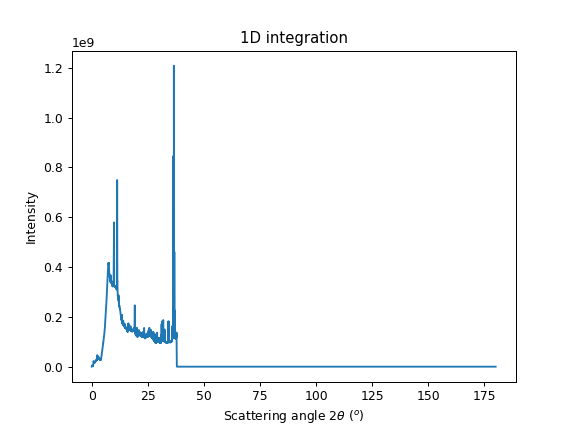

In [12]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               DatasetPathContains("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions
                              ) 

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx))),
            mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx+1)))]


samples = [mkSampleMarsTxTzP(idx) for idx in range(77, 92, 2)]
                             
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

for sample in samples:
    integrate_mars_tx_tz(json, sample, f, n=50000, save=True)

In [13]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("MARS/D03-1-CX0__EX__SPARE1-MT__#1/raw_value"),  # tx                               
                               DatasetPathContains("scan_data/actuator_1_1"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions
                              )

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx)))]


samples = [mkSampleMarsTxTzP(idx) for idx in chain(range(194, 206), 
                                                   range(211, 237),
                                                   range(238, 255))]
                             
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

for sample in samples:
    integrate_mars_tx_tz(json, sample, f, n=50000, save=True, no_plot=True)

CalibrationMarsTxTzFrame(idx=0, label='scan_194_01.nxs_0', image=array([[508, 473, 467, ..., 461, 388, 949],
       [441, 393, 336, ..., 376, 322, 883],
       [369, 395, 333, ..., 347, 341, 868],
       ..., 
       [ 34,  19,  25, ...,  22,  22,  73],
       [ 34,  18,  17, ...,  31,  24,  60],
       [ 31,  17,  25, ...,  18,  34,  59]], dtype=uint32), tx=805.00099999999998, tz=-0.00060000000000000006)
CalibrationMarsTxTzFrame(idx=1, label='scan_194_01.nxs_1', image=array([[ 489,  469,  521, ...,  403,  434, 1021],
       [ 405,  400,  397, ...,  371,  326,  930],
       [ 442,  366,  362, ...,  363,  344,  868],
       ..., 
       [   7,   14,   10, ...,   10,   14,   24],
       [  10,   16,    7, ...,   12,   11,   21],
       [  23,   12,    6, ...,   11,    7,   18]], dtype=uint32), tx=805.00099999999998, tz=-4.9996)
area_pixel=1.4143300979439353 area_sum=3.9780542610624776, Error= -1.812677370612083
CalibrationMarsTxTzFrame(idx=0, label='scan_195_01.nxs_0', image=array([[496,